In [1]:
import pandas as pd

# Begin clustering and evaluation

In [1]:
from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn import metrics
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.spatial.distance import cdist
from scipy.optimize import linear_sum_assignment
import pickle
import tqdm
import os
import scipy
import glob
np.random.seed(19)

#### Pick policies based on OPE/ZCP results using one OPE/ZCP metric for both steps
Please comment/uncomment `available_zones`, change `ope_location` and `zero_shot_location` based on your result folder structure.
- `available_zones`: For medium office result, please use the top one. For DOEE, please use the bottom commented one.
- `ope_location`: OPE result from the OPE/ZCP evaluation code.
- `zero_shot_location`: aggregated transfer evaluation result of the whole policy library on the corresponding building.

In [142]:
available_zones = ['Core_top', 'Core_mid', 'Core_bottom',
                   'Perimeter_top_ZN_3', 'Perimeter_top_ZN_2', 'Perimeter_top_ZN_1', 'Perimeter_top_ZN_4',
                   'Perimeter_bot_ZN_3', 'Perimeter_bot_ZN_2', 'Perimeter_bot_ZN_1', 'Perimeter_bot_ZN_4',
                   'Perimeter_mid_ZN_3', 'Perimeter_mid_ZN_2', 'Perimeter_mid_ZN_1', 'Perimeter_mid_ZN_4']
# available_zones = ["Amphitheater", "Lab", "Library",
#                    "North-1", "North-2", "North-3", "North-G",
#                    "South-1", "South-2", "South-3", "South-GF"]
num_clusters = 6
num_pick = 10
picked_policies = dict()
ope_results = dict()

ope_location = "ope/ope_rotate/**.pkl"
zero_shot_location = "zeroshot/zeroshot_newloc_1_doee_0"

for algorithm in glob.glob(ope_location):
    picked_policies[algorithm] = dict()
    with open(algorithm, "rb") as obj:
        ope_results[algorithm] = pickle.load(obj)

for zone in tqdm.tqdm(range(len(available_zones))):
    df = pd.read_csv(f"{zero_shot_location}/zero-shot_zone_{zone}.csv")
    for algorithm in glob.glob(ope_location):
        df[algorithm] = df["name"]

        for i in range(df.shape[0]):
            df[algorithm].values[i] = ope_results[algorithm]["../" + df[algorithm].values[i]][available_zones[zone]]
        
        df[algorithm] = df[algorithm].astype(float)

    X = df[["init_action", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    cluster_algorithm = KMeans(n_clusters=num_clusters, random_state=19).fit(X)
    df["cluster_id"] = cluster_algorithm.labels_

    # choose based on their distance to the centroid
    distance = (cluster_algorithm.transform(X) ** 2).sum(axis=1)
    
    df["cluster_distance"] = distance
    df.to_csv(f"{zero_shot_location}/zone_{zone}_cluster_result_with_ope_results.csv")
    picked_nodes = None

    # Center + random others
    for cluster in range(num_clusters):
        l = np.sum(cluster_algorithm.labels_ == cluster)
        selected_rank = random.sample(range(1, l), num_pick - 1)
        selected_rank.append(0)
        idxs = np.array([False] * l)
        for r in selected_rank:
            idxs = idxs | (distance[cluster_algorithm.labels_ == cluster].argsort() == r)
        if picked_nodes is None:
            picked_nodes = df[df["cluster_id"] == cluster][idxs]
        else:
            picked_nodes = pd.concat([picked_nodes, df[df["cluster_id"] == cluster][idxs]])
    
    
    # Pick the maximum value of all picked policies
    first_round_result = picked_nodes.groupby("cluster_id").agg("max")

    # Find top 50% clusters, and rerun OPE to pick the best policy
    for algorithm in glob.glob(ope_location):
        lower_bound = sorted(first_round_result[algorithm])[0]
#         lower_bound = sorted(first_round_result[algorithm])[num_clusters // 2 - 1]
        candidates = df[df["cluster_id"].isin(first_round_result[first_round_result[algorithm] > lower_bound].index.values)]
        picked_policies[algorithm][available_zones[zone]] = candidates[candidates[algorithm] == candidates[algorithm].max()]["name"].values[0]

100%|███████████████████████████████████████████| 15/15 [00:03<00:00,  4.92it/s]


To selected policies using proposed methodology, run the following cell. Please modify the file path at line 37 and 38 to the correct location based on your folder structure.

In [48]:
picked_policies["GK-SNIP"] = dict()
for zone in tqdm.tqdm(range(len(available_zones))):
    df = pd.read_csv(f"{zero_shot_location}/zero-shot_zone_{zone}.csv")
    for algorithm in glob.glob(ope_location):
        df[algorithm] = df["name"]

        for i in range(df.shape[0]):
            df[algorithm].values[i] = ope_results[algorithm]["../" + df[algorithm].values[i]][available_zones[zone]]
        
        df[algorithm] = df[algorithm].astype(float)

    X = df[["init_action", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    cluster_algorithm = KMeans(n_clusters=num_clusters, random_state=19).fit(X)
    df["cluster_id"] = cluster_algorithm.labels_

    # choose based on their distance to the centroid
    distance = (cluster_algorithm.transform(X) ** 2).sum(axis=1)
    picked_nodes = None
    # Pick all closest policies
    for cluster in range(num_clusters):
        l = np.sum(cluster_algorithm.labels_ == cluster)
        selected_rank = random.sample(range(1, l), num_pick - 1)
        selected_rank.append(0)
        idxs = np.array([False] * l)
        for r in selected_rank:
            idxs = idxs | (distance[cluster_algorithm.labels_ == cluster].argsort() == r)
        if picked_nodes is None:
            picked_nodes = df[df["cluster_id"] == cluster][idxs]
        else:
            picked_nodes = pd.concat([picked_nodes, df[df["cluster_id"] == cluster][idxs]])

    # Pick the maximum value of all picked policies
    first_round_result = picked_nodes.groupby("cluster_id").agg("max")

    # Find top cluster, and rerun OPE to pick the best policy
    for algorithm in ['ope/ope_doee/snip_raw_scores.pkl']:
        lower_bound = sorted(first_round_result['ope/ope_doee/GaussianKernel.pkl'])[0]
        candidates = df[df["cluster_id"].isin(first_round_result[first_round_result['ope/ope_doee/GaussianKernel.pkl'] > lower_bound].index.values)]
        picked_policies["GK-SNIP"][available_zones[zone]] = candidates[candidates[algorithm] == candidates[algorithm].max()]["name"].values[0]

100%|███████████████████████████████████████████| 11/11 [00:01<00:00,  6.45it/s]


Get baseline policy selection results if the ground truth performance result is known.

In [49]:
picked_policies["PI_BOTH"] = dict()
for zone in tqdm.tqdm(range(len(available_zones))):
    df = pd.read_csv(f"{zero_shot_location}/zero-shot_zone_{zone}.csv")
    df = df.sort_values(by="optimal")
    picked_policies["PI_BOTH"][available_zones[zone]] = df.iloc[0, 0]
    
picked_policies["PI_NONE"] = dict()
for zone in tqdm.tqdm(range(len(available_zones))):
    df = pd.read_csv(f"{zero_shot_location}/zero-shot_zone_{zone}.csv")
    df = df.sort_values(by="optimal")
    i = 0
    while True:
        if 'e' not in df.iloc[i, 0] and "blind" not in df.iloc[i, 0]:
            break
        i += 1
    picked_policies["PI_NONE"][available_zones[zone]] = df.iloc[i, 0]
    
picked_policies["PI_POLICY"] = dict()
for zone in tqdm.tqdm(range(len(available_zones))):
    df = pd.read_csv(f"{zero_shot_location}/zero-shot_zone_{zone}.csv")
    df = df.sort_values(by="optimal")
    i = 0
    while True:
        if 'blind' not in df.iloc[i, 0]:
            break
        i += 1
    picked_policies["PI_POLICY"][available_zones[zone]] = df.iloc[i, 0]
    
picked_policies["PI_ENV"] = dict()
for zone in tqdm.tqdm(range(len(available_zones))):
    df = pd.read_csv(f"{zero_shot_location}/zero-shot_zone_{zone}.csv")
    df = df.sort_values(by="optimal")
    i = 0
    while True:
        if 'e' not in df.iloc[i, 0]:
            break
        i += 1
    picked_policies["PI_ENV"][available_zones[zone]] = df.iloc[i, 0]

100%|██████████████████████████████████████████| 11/11 [00:00<00:00, 100.05it/s]


#### Plot the elbow method inertia plot for different number of clusters

Here is an example plotting the result for a medium office.

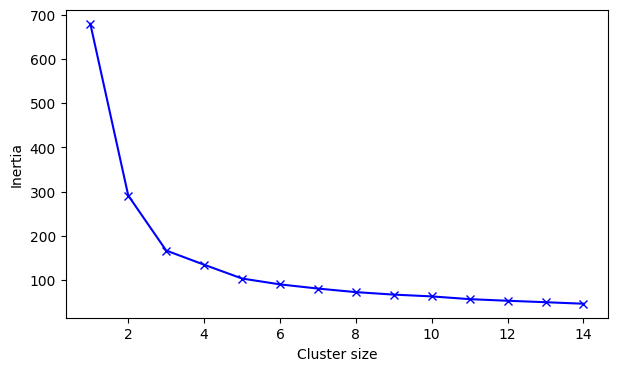

100%|█████████████████████████████████████████████| 1/1 [00:06<00:00,  6.34s/it]


In [124]:
available_zones = ['Core_top', 'Core_mid', 'Core_bottom',
                   'Perimeter_top_ZN_3', 'Perimeter_top_ZN_2', 'Perimeter_top_ZN_1', 'Perimeter_top_ZN_4',
                   'Perimeter_bot_ZN_3', 'Perimeter_bot_ZN_2', 'Perimeter_bot_ZN_1', 'Perimeter_bot_ZN_4',
                   'Perimeter_mid_ZN_3', 'Perimeter_mid_ZN_2', 'Perimeter_mid_ZN_1', 'Perimeter_mid_ZN_4']

num_pick = 10
picked_policies = dict()
ope_results = dict()

for algorithm in glob.glob("ope/normal/**.pkl"):
    picked_policies[algorithm] = dict()
    with open(algorithm, "rb") as obj:
        ope_results[algorithm] = pickle.load(obj)

for zone in tqdm.tqdm(range(14, 15)):
    df = pd.read_csv(f"zeroshot_newloc_0_doee_0/zero-shot_zone_{zone}.csv")
    for algorithm in glob.glob("ope/normal/**.pkl"):
        df[algorithm] = df["name"]

        for i in range(df.shape[0]):
            df[algorithm].values[i] = ope_results[algorithm]["../" + df[algorithm].values[i]][available_zones[zone]]
        
        df[algorithm] = df[algorithm].astype(float)

    X = df[["init_action", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))
  
    inertias = []
    inertias_diff = []
    K = range(1, 15)
    for k in K:
        # Building and fitting the model
        kmeanModel = KMeans(n_clusters=k).fit(X)
        kmeanModel.fit(X)
        inertias.append(kmeanModel.inertia_)
    
    for i in range(1, len(inertias)):
        inertias_diff.append(inertias[i] - inertias[i - 1])

    plt.figure(figsize=(7, 4))
    plt.plot(K, inertias, 'bx-')
    plt.xlabel('Cluster size')
    plt.ylabel('Inertia')
#     plt.title('The Elbow Method using Inertia')
#     print(inertias_diff)
#     plt.title('Inertia difference')
    plt.savefig("inertia.pdf", bbox_inches="tight")
    plt.show()

In [50]:
# Check policies selected using various techniques
picked_policies

{'ope/ope_doee/GaussianKernel_0.03_15_days_14_09_2022.pkl': {'Amphitheater': 'policy_library_20220820/101_0_1e0_blind.pth',
  'Lab': 'policy_library_20220820/101_0_1e0_blind.pth',
  'Library': 'policy_library_20220820/101_0_1e0_blind.pth',
  'North-1': 'policy_library_20220820/101_0_1e0_blind.pth',
  'North-2': 'policy_library_20220820/101_0_1e-1_blind.pth',
  'North-3': 'policy_library_20220820/101_0_1e-1_blind.pth',
  'North-G': 'policy_library_20220820/101_0_1e-1_blind.pth',
  'South-1': 'policy_library_20220820/101_0_1e-1_blind.pth',
  'South-2': 'policy_library_20220820/101_0_1e-1_blind.pth',
  'South-3': 'policy_library_20220820/101_0_1e0_blind.pth',
  'South-GF': 'policy_library_20220820/101_0_1e-1_blind.pth'},
 'ope/ope_doee/snip_raw_scores_15_days_14_09_2022.pkl': {'Amphitheater': 'policy_library_20220820/118_4_1e1_2.pth',
  'Lab': 'policy_library_20220820/118_4_1e1_2.pth',
  'Library': 'policy_library_20220820/118_4_1e1_2.pth',
  'North-1': 'policy_library_20220820/118_4_1e1_

#### Plot the CDF result for clusters

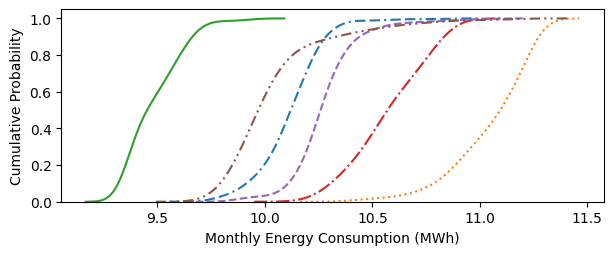

In [139]:
linestyles = [(0, (5, 2, 1, 2, 1, 2)), '--', '-.', '-', ':', (0, (5, 2, 5, 2, 1, 2))]
for num_clusters in range(6, 7):
    X = df[["init_action", "p0", "p1", "p2", "p3", "p4", "p5", "p6", "p7", "p8", "p9"]].apply(lambda x: (x - x.min()) / (x.max() - x.min()))

    cluster_algorithm = KMeans(n_clusters=num_clusters, algorithm="elkan", random_state=123).fit(X)

    plt.figure(figsize=(7, 2.5))
    for cluster_id in range(num_clusters):
        sns.kdeplot(df[cluster_algorithm.labels_ == cluster_id]["optimal"] / 1380000,
                    label=f"{cluster_id}: {np.sum(cluster_algorithm.labels_ == cluster_id)}",
                    cumulative=True,
                    linestyle=linestyles.pop())
    result = 0

    plt.xlabel("Monthly Energy Consumption (MWh)")
    plt.ylabel("Cumulative Probability")
    plt.savefig("density.pdf", bbox_inches="tight")
    plt.show()

# Plotting result

Use results from the experiment code to generate plots.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import os

For building B_Denver

In [41]:
algorithms = list()
for path in glob.glob("evaluate_csvs/logs_cedar/**.csv"):
    basename = os.path.basename(path)
    if "newloc_0" not in basename:
        continue
    case_name = basename[:basename.index('_seed')] + '_seed*'
    if "Scratch" in case_name:
        case_name = '*' + basename[basename[14:].index('_') + 14:]
    if case_name not in algorithms:
        algorithms.append(case_name)
print(algorithms)

['GK-SNIP_seed*', '*_diverse_1_all_1_scratch_1_cluster_-1_SA_0_ignore_0_newloc_0-log.csv', '*_diverse_1_all_1_scratch_1_cluster_-1_SA_1_ignore_0_newloc_0-log.csv', 'PI_BOTH_seed*', 'SNIP_seed*', 'GK_seed*']


5.41, 4.86, GK-SNIP*
13.77, 13.17, MARL
13.74, 12.23, SARL
3.99, 3.84, Optimal
10.21, 9.15, GK-GK
6.981998551417798 Default controller


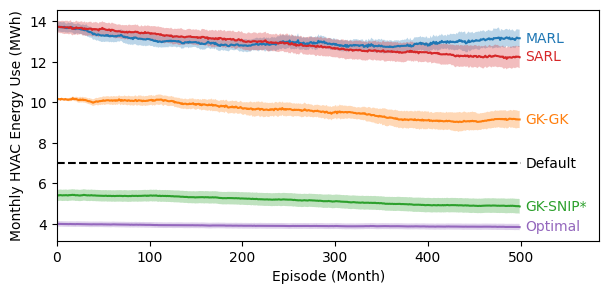

In [43]:
plt.figure(figsize=(7, 3))
label_dic = {'*_diverse_1_all_1_scratch_1_cluster_-1_SA_1_ignore_0_newloc_0-log.csv': ["SARL", 'tab:red'],
             'GK-SNIP_seed*': ["GK-SNIP*", 'tab:green'],
             '*_diverse_1_all_1_scratch_1_cluster_-1_SA_0_ignore_0_newloc_0-log.csv': ["MARL", 'tab:blue'],
             'GK_seed**_diverse_1_all_1_scratch_0_cluster_6_SA_0_ignore_0-log.csv': ["GK-GK", 'tab:orange'],
#              'SNIP_seed*': ["SNIP-SNIP", "red"],
             'PI_BOTH_seed*': ["Optimal", 'tab:purple']}
gk_snip = None
for alg in algorithms:
    if alg not in label_dic:
        continue
    all_results = list()
    for path in glob.glob(f"evaluate_csvs/logs_cedar_2/{alg}"):
        if "newloc_0" not in path and "GK" not in path:
            continue
        values = list()
        with open(path, 'r') as csv_file:
            for line in csv_file:
                if line[0] != '[':
                    continue
                values.append(float(line.strip()[line.index("energy: ") + 7:]))
                if len(values) == 500:
                    break
        if len(values) < 500:
            continue
        all_results.append(values)

    if not all_results:
        print(path)
    mean = np.mean(all_results, axis=0)
    std = np.std(all_results, axis=0)
    
    plt.fill_between(range(len(mean)), mean + std, mean - std, alpha=0.3, color=label_dic[alg][1], edgecolor=None)
    plt.plot(mean, label=label_dic[alg][0], color=label_dic[alg][1])
    plt.text(505, mean[-1], label_dic[alg][0], va='center', color=label_dic[alg][1])
    print(f"{mean[0]:.2f}, {mean[-1]:.2f}, {label_dic[alg][0]}")

baseline = 6.981998551417798
plt.hlines(baseline, 0, 500, linestyle="--", color="black", label="Default controller")
plt.text(505, baseline, "Default", va='center')
print(baseline, "Default controller")
plt.xlabel("Episode (Month)")
plt.ylabel("Monthly HVAC Energy Use (MWh)")
plt.xlim([0, 585])
plt.xticks([0, 100, 200, 300, 400, 500])
plt.savefig("building_B.pdf", bbox_inches="tight")
plt.show()

For building B_SF

In [38]:
algorithms = list()
for path in glob.glob("evaluate_csvs/logs_graham/**.csv"):
    basename = os.path.basename(path)
    if "newloc_1" not in basename:
        continue
    case_name = basename[:basename.index('_seed')] + '_seed*'
    if "Scratch" in case_name:
        case_name = '*' + basename[basename[14:].index('_') + 14:]
    if case_name not in algorithms:
        algorithms.append(case_name)
print(algorithms)

['GK_seed*', '*_diverse_1_all_1_scratch_1_cluster_-1_SA_1_ignore_0_newloc_1-log.csv', '*_diverse_1_all_1_scratch_1_cluster_-1_SA_0_ignore_0_newloc_1-log.csv', 'GK-SNIP_seed*', 'SNIP_seed*', 'PI_BOTH_seed*']


6.02, 4.23, GK-GK
13.18, 10.70, SARL
12.86, 7.89, MARL
3.31, 2.97, GK-SNIP*
2.01, 2.01, Optimal
3.959770250474354 Default controller


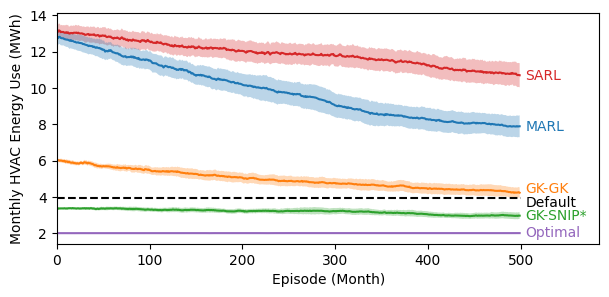

In [40]:
plt.figure(figsize=(7, 3))
label_dic = {'*_diverse_1_all_1_scratch_1_cluster_-1_SA_1_ignore_0_newloc_1-log.csv': ["SARL", 'tab:red'],
             'GK-SNIP_seed*': ["GK-SNIP*", 'tab:green'],
             '*_diverse_1_all_1_scratch_1_cluster_-1_SA_0_ignore_0_newloc_1-log.csv': ["MARL", 'tab:blue'],
             'GK_seed*': ["GK-GK", 'tab:orange'],
#              'SNIP_seed*': ["SNIP-SNIP", "black"],
             'PI_BOTH_seed*': ["Optimal", 'tab:purple']}
gk_snip = None
for alg in algorithms:
#     if "ignore_1" in alg or "GN" in alg or "PI_NONE" in alg or "PI_ENV" in alg:
#         continue
    if alg not in label_dic:
        continue
    all_results = list()
    for path in glob.glob(f"evaluate_csvs/logs_graham/{alg}"):
        if "newloc_1" not in path:
            continue
        values = list()
        with open(path, 'r') as csv_file:
            for line in csv_file:
                if line[0] != '[':
                    continue
                values.append(float(line.strip()[line.index("energy: ") + 7:]))
                if len(values) == 500:
                    break
        if len(values) < 500:
            continue
        all_results.append(values)

    if not all_results:
        print(path)
    mean = np.mean(all_results, axis=0)
    std = np.std(all_results, axis=0)
    
    plt.fill_between(range(500), mean + std, mean - std, alpha=0.3, color=label_dic[alg][1], edgecolor=None)
    plt.plot(mean, label=label_dic[alg][0], color=label_dic[alg][1])
    if label_dic[alg][1] == "tab:orange":
        plt.text(505, mean[-1] + 0.2, label_dic[alg][0], va='center', color=label_dic[alg][1])
    else:
        plt.text(505, mean[-1], label_dic[alg][0], va='center', color=label_dic[alg][1])
    print(f"{mean[0]:.2f}, {mean[-1]:.2f}, {label_dic[alg][0]}")

# with open("evaluate_csvs/B_SF_mu.pkl", "rb") as pkl:
#     mean = pd.Series(pickle.load(pkl)).rolling(window=50).mean().values[50:]
# with open("evaluate_csvs/B_SF_sigma.pkl", "rb") as pkl:
#     std = pd.Series(pickle.load(pkl)).rolling(window=50).mean().values[50:]

# plt.plot(range(50, 500), mean, label="UCB", color="tab:olive")
# plt.fill_between(range(50, 500), mean + std, mean - std, alpha=0.3, color="tab:olive", edgecolor=None)
# plt.text(505, mean[-1] + 0.2, "UCB", va='center', color="tab:olive")    

baseline = 3.959770250474354
plt.hlines(baseline, 0, 500, linestyle="--", color="black", label="Default controller")
plt.text(505, baseline - 0.3, "Default", va='center')
print(baseline, "Default controller")
# plt.legend()
plt.xlabel("Episode (Month)")
plt.ylabel("Monthly HVAC Energy Use (MWh)")
plt.xlim([0, 585])
plt.xticks([0, 100, 200, 300, 400, 500])
plt.savefig("building_C.pdf", bbox_inches="tight")
plt.show()

For Building C

In [33]:
algorithms = list()
for path in glob.glob("evaluate_csvs/logs_graham/**.csv"):
    basename = os.path.basename(path)
    if "_doee" not in basename:
        continue
    case_name = basename[:basename.index('_seed')] + '_seed*'
    if "Scratch" in case_name:
        case_name = '*' + basename[basename[14:].index('_') + 14:]
    if case_name not in algorithms:
        algorithms.append(case_name)
print(algorithms)

['*_diverse_1_all_1_scratch_1_cluster_-1_SA_1_ignore_0_newloc_0_doee-log.csv', 'GK-SNIP_seed*', '*_diverse_1_all_1_scratch_1_cluster_-1_SA_0_ignore_0_newloc_0_doee-log.csv', 'GK_seed*', 'SNIP_seed*', 'PI_BOTH_seed*']


6.264, 5.820, SARL
6.272, 5.543, MARL
5.762, 5.123, GK-GK
4.712, 4.641, GK-SNIP*
4.413, 4.411, Optimal
4.8343394367283175 Default controller


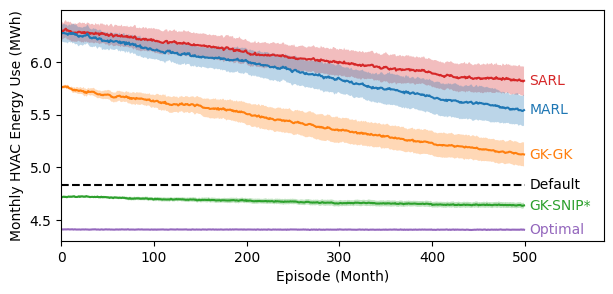

In [37]:
plt.figure(figsize=(7, 3))
label_dic = {'*_diverse_1_all_1_scratch_1_cluster_-1_SA_1_ignore_0_newloc_0_doee-log.csv': ["SARL", 'tab:red'],
#              'SNIP_seed*': ["SNIP-SNIP", "black"],
             '*_diverse_1_all_1_scratch_1_cluster_-1_SA_0_ignore_0_newloc_0_doee-log.csv': ["MARL", 'tab:blue'],
             'GK_seed*': ["GK-GK", 'tab:orange'],
             'GK-SNIP_seed*': ["GK-SNIP*", 'tab:green'],
             'PI_BOTH_seed*': ["Optimal", 'tab:purple']}
for alg in algorithms:
#     if "ignore_1" in alg or "GN" in alg or "PI_NONE" in alg or "PI_ENV" in alg:
#         continue
    if alg not in label_dic:
        continue
    all_results = list()
    for path in glob.glob(f"evaluate_csvs/logs_graham/{alg}"):
        if "_doee" not in path:
            continue
        values = list()
        with open(path, 'r') as csv_file:
            for line in csv_file:
                if line[0] != '[':
                    continue
                values.append(float(line.strip()[line.index("energy: ") + 7:]))
                if len(values) == 500:
                    break
        if len(values) < 500:
            continue
        all_results.append(values)

    if not all_results:
        print(path)
    mean = np.mean(all_results, axis=0)
    std = np.std(all_results, axis=0)
    
    plt.fill_between(range(500), mean + std, mean - std, alpha=0.3, color=label_dic[alg][1], edgecolor=None)
    plt.plot(mean, label=label_dic[alg][0], color=label_dic[alg][1])
    plt.text(505, mean[-1], label_dic[alg][0], va='center', color=label_dic[alg][1])
    print(f"{mean[0]:.3f}, {mean[-1]:.3f}, {label_dic[alg][0]}")
baseline = 4.8343394367283175
plt.hlines(baseline, 0, 500, linestyle="--", color="black", label="Default controller")
plt.text(505, baseline, "Default", va='center')
print(baseline, "Default controller")
# plt.legend()
plt.xlabel("Episode (Month)")
plt.ylabel("Monthly HVAC Energy Use (MWh)")
plt.xlim([0, 585])
plt.xticks([0, 100, 200, 300, 400, 500])
plt.savefig("building_D.pdf", bbox_inches="tight")
plt.show()